# Importing Libraries and initial setup

In [84]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-nfxxonsc
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-nfxxonsc
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done


In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict, deque
from tqdm import tqdm
import tensorflow as tf
import random
import io
from contextlib import redirect_stdout

import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym

# Utility Funtions and Variables

In [3]:
all_the_q_tables = {}
all_reward_sums = {} # Contains sum of rewards during run
all_scores_sums = {} # Contains sum of scores during run
actions = []

In [86]:
def get_state(state):
  if isinstance(state[0], tuple):
      return state[0]
  elif isinstance(state[0], int):
      return state

In [88]:
def plot_charts(algorithms, colors):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(25, 6))
    for i, algorithm in enumerate(algorithms):
    # Plot the first chart in the first subplot
      axs[0].plot(all_reward_sums[algorithm], label=algorithm, color=colors[0][i])
    axs[0].set_xlabel("Episodes")
    axs[0].set_ylabel("Sum of rewards during episode", rotation=90)

    for i, algorithm in enumerate(algorithms):
    # Plot the second chart in the second subplot
      axs[1].plot(all_scores_sums[algorithm], label=algorithm, color=colors[1][i])
    axs[1].set_xlabel("Episodes")
    axs[1].set_ylabel("Sum of Scores during episode", rotation=90)
    
    if len(algorithms) == 1:
      title = algorithm
    else:
      title = "Comparison of algorithms"
      axs[0].legend()
      axs[1].legend()
    # Add a common title to the entire figure
    fig.suptitle(title, fontsize=14, fontweight='bold')
    # Display the figure
    plt.show()


# Random Agent

In [89]:
class RandomAgent():
    def __init__(self, params):
        self.epsilon = params["epsilon"]                      # Epsilon threshold start for exploration
        self.epsilon_decay = params["epsilon_decay"]              # Epsilon decay rate
        self.alpha = params["alpha"]                          # Step size 
        self.alpha_decay = params["alpha_decay"]              # Step size decay rate
        self.gamma = params["gamma"]                          # Discount factor     
        
    def choose_action(self, state): 
        action = env.action_space.sample()
        return action

    def update(self, decay = False):
        pass

# Q-Learning Agent

In [90]:
class QLearning_Agent():
    def __init__(self, params):
        self.epsilon = params["epsilon"]                      # Epsilon threshold start for exploration
        self.epsilon_decay = params["epsilon_decay"]              # Epsilon decay rate
        self.alpha = params["alpha"]                          # Step size 
        self.alpha_decay = params["alpha_decay"]              # Step size decay rate
        self.gamma = params["gamma"]                          # Discount factor

    def argmax(self, q_values):                                              
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)
        return np.random.choice(ties)

    def choose_action(self, state): #epsilon-greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            action = env.action_space.sample()
            return action
        else:
            action = self.argmax(q[state])
            return action
        
    def update(self, state, next_state, action, reward, decay = False):
        old_value = q[state][action]
        next_max = np.max(q[next_state])
        
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward +  self.gamma * next_max)
        q[state][action] = new_value
        return (old_value, new_value)

        if (decay == True):
            # Decay for the step-size
            if self.alpha > 0.1:
                self.alpha = max(self.alpha * self.alpha_decay, 0.1) 

            # Decay for the epsilon
            if self.epsilon > 0.0001:
                self.epsilon = max(self.epsilon * self.epsilon_decay, 0.0001) 


# Sarsa Agent

In [91]:
class Sarsa_Agent():
    def __init__(self, params):
        self.epsilon = params["epsilon"]                      # Epsilon threshold start for exploration
        self.epsilon_decay = params["epsilon_decay"]              # Epsilon decay rate
        self.alpha = params["alpha"]                          # Step size 
        self.alpha_decay = params["alpha_decay"]              # Step size decay rate
        self.gamma = params["gamma"]                          # Discount factor

    def argmax(self, q_values):                                              
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)
        return np.random.choice(ties)

    def choose_action(self, state): #epsilon-greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            action = env.action_space.sample()
            return action
        else:
            action = self.argmax(q[state])
            return action
        
    def update(self, state, next_state, action, reward, decay = False):
        old_value = q[state][action]
        next_action = self.choose_action(next_state)

        next_value = q[next_state][next_action]
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward +  self.gamma * next_value)
        q[state][action] = new_value
        return (old_value, new_value)

        if (decay == True):
            # Decay for the step-size
            if self.alpha > 0.1:
                self.alpha = max(self.alpha * self.alpha_decay, 0.1) 

            # Decay for the epsilon
            if self.epsilon > 0.0001:
                self.epsilon = max(self.epsilon * self.epsilon_decay, 0.0001) 


# Monte Carlo Agent

In [92]:
class MonteCarlo_Agent():
    def __init__(self, params):
        self.epsilon = params["epsilon"]                      # Epsilon threshold start for exploration
        self.epsilon_decay = params["epsilon_decay"]              # Epsilon decay rate
        self.alpha = params["alpha"]                          # Step size 
        self.alpha_decay = params["alpha_decay"]              # Step size decay rate
        self.gamma = params["gamma"]                          # Discount factor
        self.returns = defaultdict(list)

        
    def argmax(self, q_values):                                              
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)
        return np.random.choice(ties)

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = env.action_space.sample()
            return action
        else:
            action = self.argmax(q[state])
            return action

    def update(self, episode, decay = False):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            if state not in states[:i]:
                G = sum(rewards[i:]*discounts[:-(1+i)])
                self.returns[state].append(G)
                q[state][actions[i]] += (self.alpha / len(self.returns[state])) * (G - q[state][actions[i]])
        
        if (decay == True):
            # Decay step size and epsilon
            if self.alpha > 0.1:
                self.alpha = max(self.alpha * self.alpha_decay, 0.1) 
            if self.epsilon > 0.0001:
                self.epsilon = max(self.epsilon * self.epsilon_decay, 0.0001) 


In [93]:
agents = {"Q-learning": QLearning_Agent,
          "Sarsa": Sarsa_Agent,
          "MonteCarlo": MonteCarlo_Agent,
          "RandomAgent": RandomAgent}

# Training funtion

In [40]:
def train_agent(algorithm, params):
        q_tables = defaultdict(list)
        all_reward_sums[algorithm] = []
        all_scores_sums[algorithm] = []
        current_agent = agents[algorithm](params)
        n_runs = 10000
        for run in tqdm(range(n_runs)):
            state = env.reset()
            done = False
            total_reward = 0
            episode = []
            decay = True
            while not done:
                state = get_state(state)
                action = current_agent.choose_action(state)
                next_state, reward, done, _, info = env.step(action)
                
                if(algorithm == "MonteCarlo"):
                    episode.append((state, action, reward))

                # For SARSA acquiring the on-policy next action
                if (algorithm == "Sarsa"):
                    next_action = current_agent.choose_action(next_state)

                if done == True:
                    reward = -1

                # Update total reward 
                total_reward += reward

                #Update q values table
                if (run == 0):
                    decay = False

                if (algorithm == "Q-learning" or algorithm == "Sarsa"):
                    old_val, new_val = current_agent.update(state, next_state, action, reward, decay = decay)
                    if action == 1:
                        q_tables[state] = [old_val,new_val]
                    elif action == 0:
                        q_tables[state] = [new_val, old_val]
                elif(algorithm == "MonteCarlo"):
                    current_agent.update(episode, decay=decay)

                
                # Update state
                state = next_state
                # Player dead
                if done:
                    break

            # Print progress
            if (run + 1) % 1000 == 0:
                print("\tEpisode {}/{} complete for {} algorithm".format(run + 1, n_runs, algorithm))

            all_reward_sums[algorithm].append(total_reward)
            all_scores_sums[algorithm].append(info['score'])
        all_the_q_tables[algorithm] = q_tables
        env.close()
        return (all_reward_sums[algorithm], all_scores_sums[algorithm])

# Initial Results

In [46]:
len(all_reward_sums['Sarsa'])

10000

In [13]:
params ={'epsilon':0.2, 'alpha' : 0.7, 'gamma':0.95, 'epsilon_decay' : 0.999, 'alpha_decay' : 0.9999}
colors = (['darkgreen'],['purple'])

## Q-Learning

In [31]:
q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.
if __name__ == '__main__':
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    train_agent("Q-learning", params)
    

 10%|█         | 1046/10000 [00:03<00:28, 316.23it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 21%|██        | 2080/10000 [00:06<00:16, 467.57it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3065/10000 [00:09<00:21, 326.52it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4058/10000 [00:13<00:20, 285.37it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5056/10000 [00:16<00:17, 289.87it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6034/10000 [00:19<00:12, 316.84it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7029/10000 [00:23<00:10, 286.31it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8040/10000 [00:26<00:07, 277.53it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9065/10000 [00:30<00:02, 329.03it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:33<00:00, 302.10it/s]

	Episode 10000/10000 complete for Q-learning algorithm


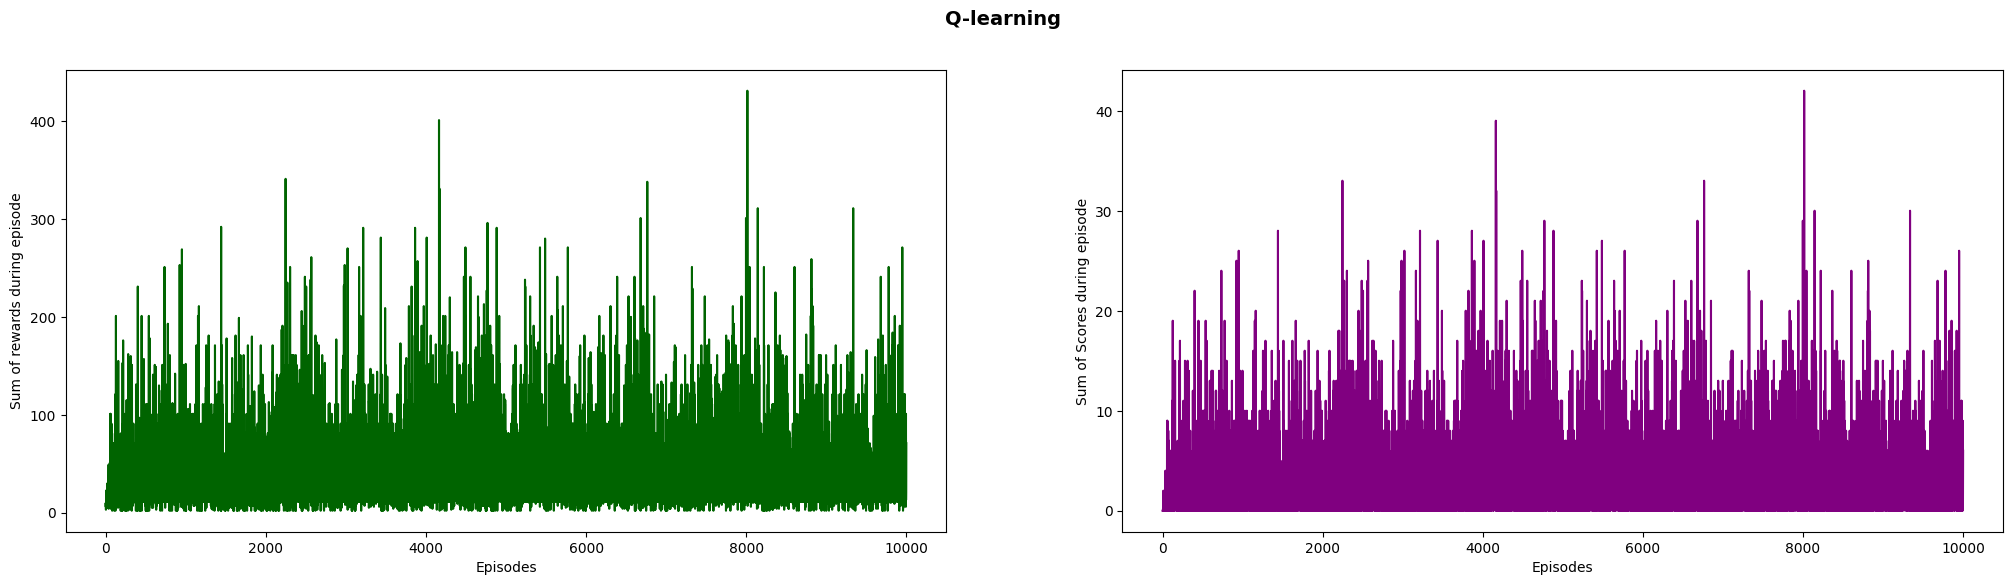

In [32]:
plot_charts(['Q-learning'], colors)

## Sarsa

In [44]:

q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.
if __name__ == '__main__':
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    train_agent("Sarsa", params)
    

 11%|█         | 1056/10000 [00:02<00:24, 370.51it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2027/10000 [00:06<00:35, 225.46it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3022/10000 [00:11<00:42, 165.48it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4024/10000 [00:16<00:33, 175.85it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5038/10000 [00:24<00:35, 138.23it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6030/10000 [00:30<00:23, 169.48it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7044/10000 [00:37<00:16, 177.52it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8024/10000 [00:43<00:12, 154.71it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9027/10000 [00:50<00:07, 137.76it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:57<00:00, 175.30it/s]

	Episode 10000/10000 complete for Sarsa algorithm


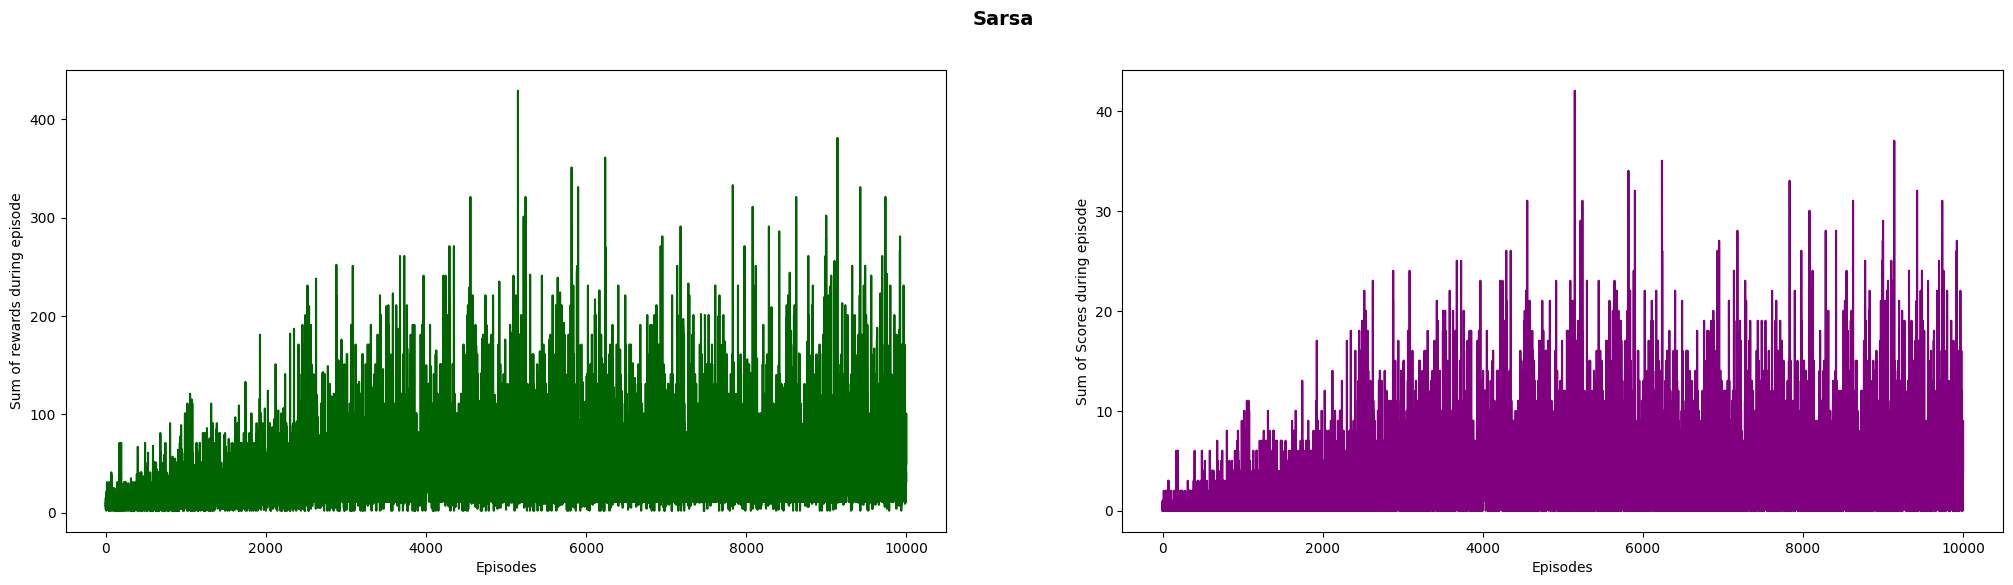

In [45]:
plot_charts(['Sarsa'], colors)

## Random Agent

In [35]:
if __name__ == '__main__':
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    train_agent("RandomAgent", params)
    

 13%|█▎        | 1327/10000 [00:00<00:03, 2689.29it/s]

	Episode 1000/10000 complete for RandomAgent algorithm


 24%|██▍       | 2405/10000 [00:00<00:02, 2554.97it/s]

	Episode 2000/10000 complete for RandomAgent algorithm


 35%|███▍      | 3487/10000 [00:01<00:02, 2650.61it/s]

	Episode 3000/10000 complete for RandomAgent algorithm


 43%|████▎     | 4278/10000 [00:01<00:02, 2587.98it/s]

	Episode 4000/10000 complete for RandomAgent algorithm


 53%|█████▎    | 5344/10000 [00:02<00:01, 2640.57it/s]

	Episode 5000/10000 complete for RandomAgent algorithm


 67%|██████▋   | 6680/10000 [00:02<00:00, 3371.08it/s]

	Episode 6000/10000 complete for RandomAgent algorithm


 76%|███████▌  | 7621/10000 [00:02<00:00, 4063.96it/s]

	Episode 7000/10000 complete for RandomAgent algorithm


 86%|████████▌ | 8575/10000 [00:02<00:00, 4437.16it/s]

	Episode 8000/10000 complete for RandomAgent algorithm
	Episode 9000/10000 complete for RandomAgent algorithm


100%|██████████| 10000/10000 [00:03<00:00, 3136.39it/s]

	Episode 10000/10000 complete for RandomAgent algorithm


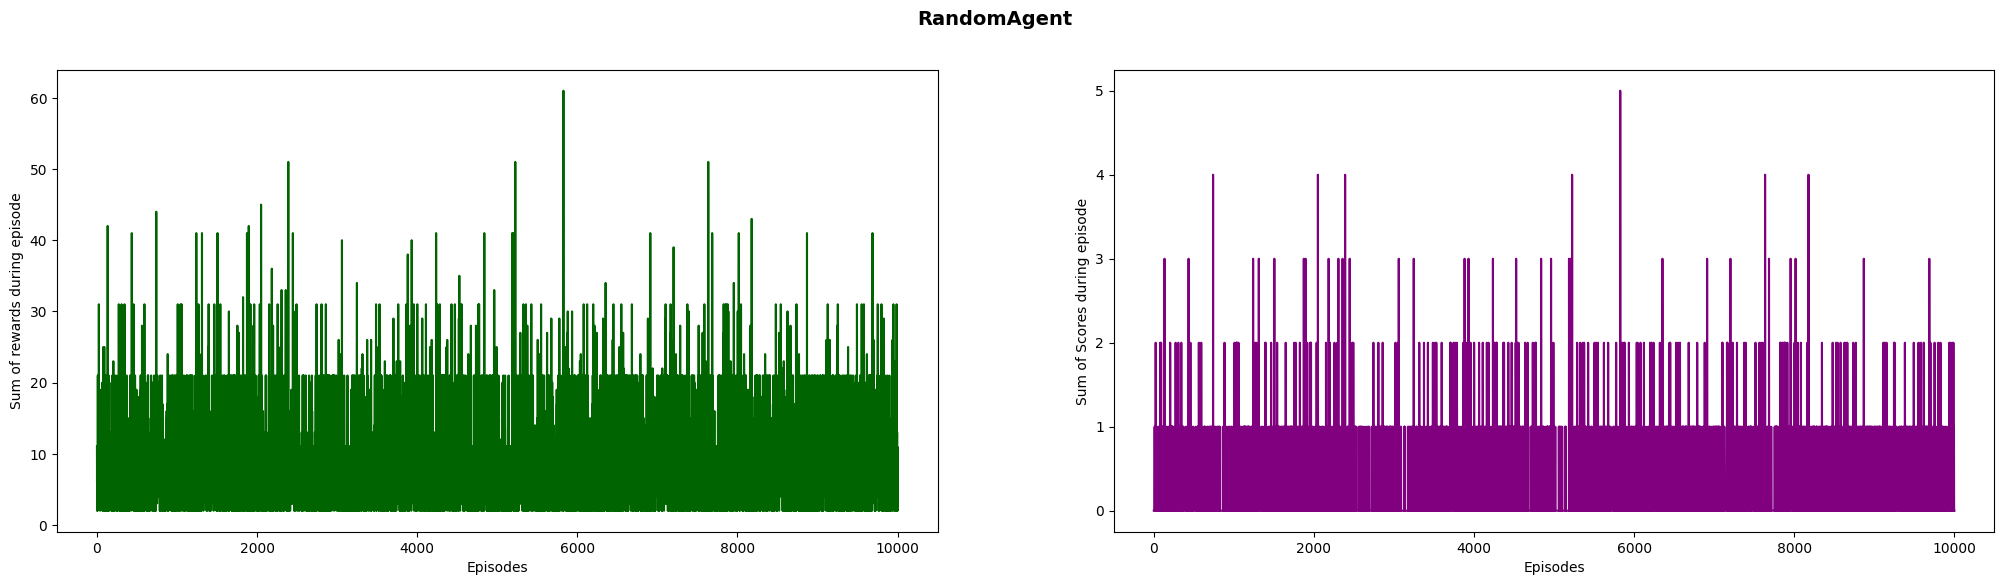

In [36]:
plot_charts(['RandomAgent'], colors)

Result Comparisons

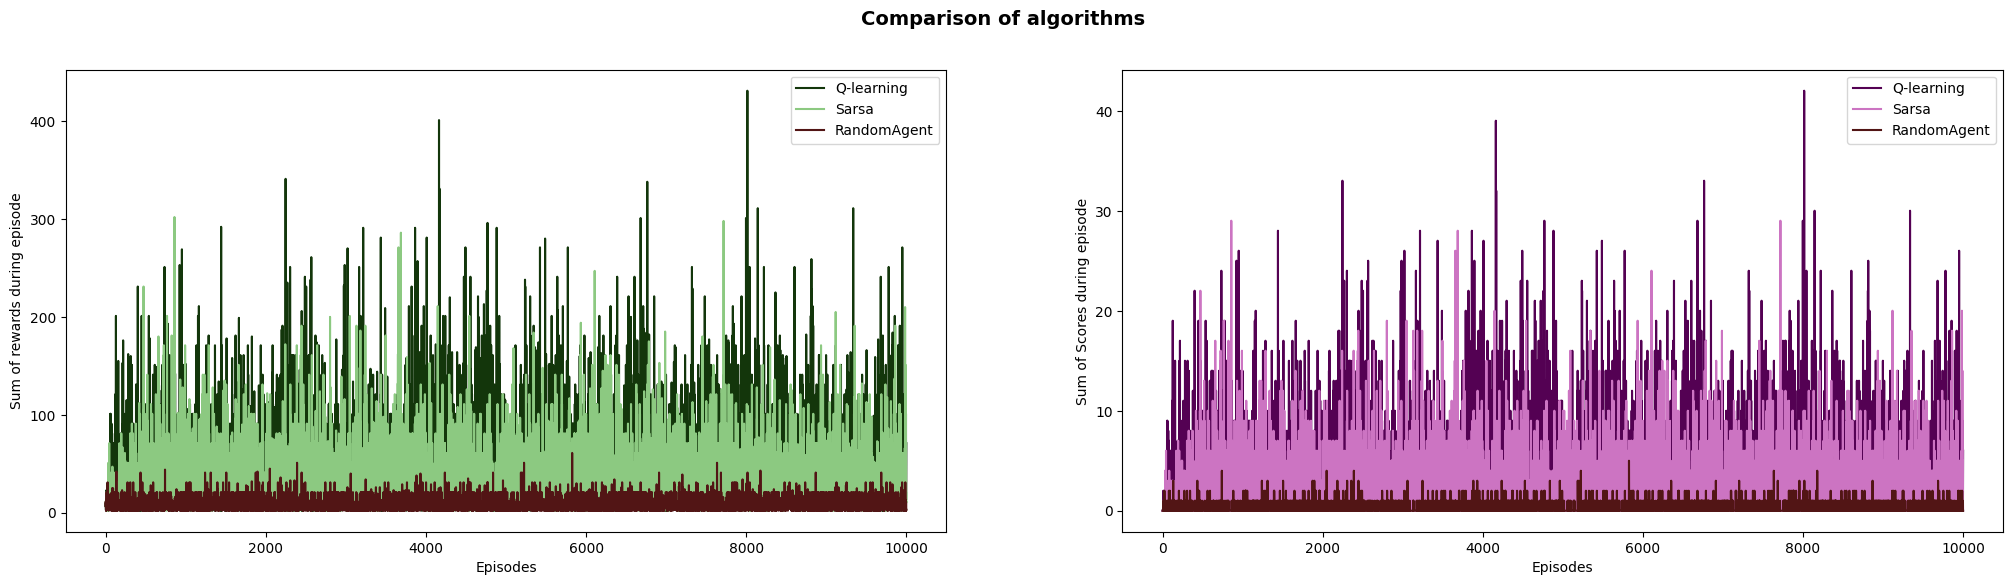

In [37]:
colors_group = (['#13360b','#8cc981', '#521515'],['#540153', '#cc74c2', '#521515'])
plot_charts([ "Q-learning", "Sarsa", "RandomAgent" ], colors_group)

# State Value Plots

## Q-Learning

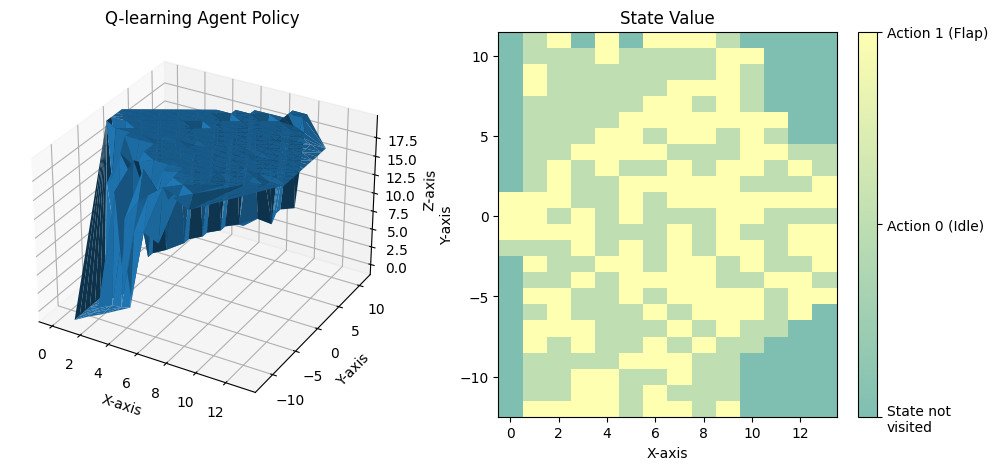

In [38]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# Create Q-policy
q_policy = dict((k, np.max(v)) for k, v in all_the_q_tables['Q-learning'].items())

# Create lists for x, y, and z values
x_list = []
y_list = []
z_list = []
for key in q_policy.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_policy.values():
    z_list.append(value)

# Create 3D projection and plot trisurface
fig = plt.figure(figsize=(12, 5))

# Add subplot for first chart
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(x_list, y_list, z_list)

# Set axis labels and title for first chart
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')
ax1.set_title('Q-learning Agent Policy')

# assume your dictionary is called q_dict
max_qvalues = {}
for state, qvalues in all_the_q_tables['Q-learning'].items():
    max_qvalues[state] = np.argmax(qvalues)

# create the mesh grid
x_range = np.arange(min(state[0] for state in all_the_q_tables['Q-learning'].keys()), max(state[0] for state in all_the_q_tables['Q-learning'].keys()) + 1)
y_range = np.arange(min(state[1] for state in all_the_q_tables['Q-learning'].keys()), max(state[1] for state in all_the_q_tables['Q-learning'].keys()) + 1)
X, Y = np.meshgrid(x_range, y_range)

# create Z values based on the maximum q-values
Z = np.zeros((len(y_range), len(x_range)))
for i, y in enumerate(y_range):
    for j, x in enumerate(x_range):
        state = (x, y)
        if state in max_qvalues:
            if max_qvalues[state] == 0:
                Z[i][j] = 1
            elif max_qvalues[state] == 1:
                Z[i][j] = 2

# Add subplot for second chart
ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(X, Y, Z, cmap='summer', alpha=0.5)

# Set axis labels and title for second chart
cbar = plt.colorbar(im, ticks=[0, 1, 2], ax=ax2)
cbar.ax.set_yticklabels(['State not \nvisited', 'Action 0 (Idle)', 'Action 1 (Flap)'])
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_title('State Value')

# Show plot
plt.show()


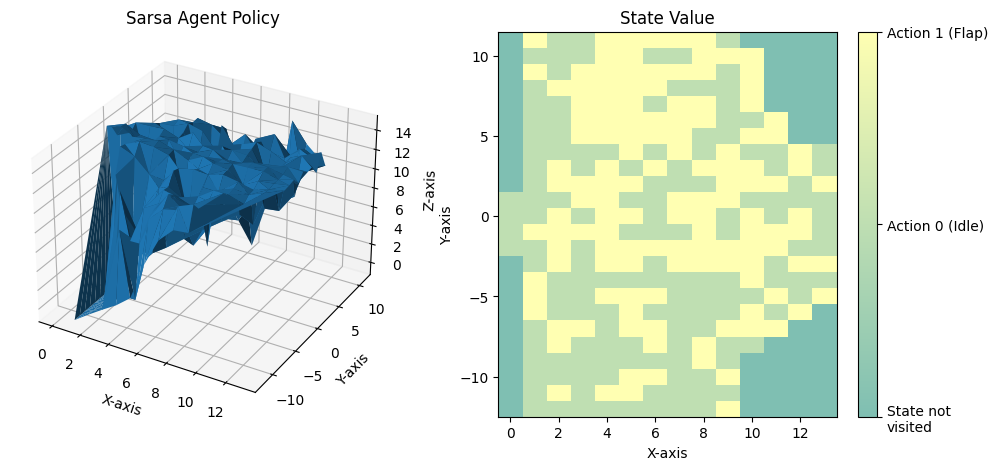

In [39]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# Create Q-policy
q_policy = dict((k, np.max(v)) for k, v in all_the_q_tables['Sarsa'].items())

# Create lists for x, y, and z values
x_list = []
y_list = []
z_list = []
for key in q_policy.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_policy.values():
    z_list.append(value)

# Create 3D projection and plot trisurface
fig = plt.figure(figsize=(12, 5))

# Add subplot for first chart
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(x_list, y_list, z_list)

# Set axis labels and title for first chart
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')
ax1.set_title('Sarsa Agent Policy')

# assume your dictionary is called q_dict
max_qvalues = {}
for state, qvalues in all_the_q_tables['Sarsa'].items():
    max_qvalues[state] = np.argmax(qvalues)

# create the mesh grid
x_range = np.arange(min(state[0] for state in all_the_q_tables['Sarsa'].keys()), max(state[0] for state in all_the_q_tables['Sarsa'].keys()) + 1)
y_range = np.arange(min(state[1] for state in all_the_q_tables['Sarsa'].keys()), max(state[1] for state in all_the_q_tables['Sarsa'].keys()) + 1)
X, Y = np.meshgrid(x_range, y_range)

# create Z values based on the maximum q-values
Z = np.zeros((len(y_range), len(x_range)))
for i, y in enumerate(y_range):
    for j, x in enumerate(x_range):
        state = (x, y)
        if state in max_qvalues:
            if max_qvalues[state] == 0:
                Z[i][j] = 1
            elif max_qvalues[state] == 1:
                Z[i][j] = 2

# Add subplot for second chart
ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(X, Y, Z, cmap='summer', alpha=0.5)

# Set axis labels and title for second chart
cbar = plt.colorbar(im, ticks=[0, 1, 2], ax=ax2)
cbar.ax.set_yticklabels(['State not \nvisited', 'Action 0 (Idle)', 'Action 1 (Flap)'])
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_title('State Value')

# Show plot
plt.show()


# Hyper-parameter Tuning

## Q-Learning

### Alpha

In [59]:
agents = {
    "Q-learning": QLearning_Agent,
    "Sarsa": Sarsa_Agent
}

all_the_q_tables = {}
all_reward_sums = {}
alphas = np.linspace(0.1,1.0,10)
num_episodes = 10000
all_scores_sums = {}
q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.
if __name__ == '__main__':
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    
    for algorithm in ["Q-learning", "Sarsa"]:
        for alpha in alphas:
            reward_for_step = 0
            params =  params ={'epsilon':0.2, 'alpha' : alpha, 'gamma':0.95, 'epsilon_decay' : 0.999, 'alpha_decay' : 0.9999}
            print("Step-size = " , alpha )
            reward_for_step, score_for_step = train_agent(algorithm, params)
                
            all_reward_sums[(algorithm, alpha)] = []    
            all_reward_sums[(algorithm, alpha)].append(reward_for_step)
            all_scores_sums[(algorithm, alpha)] = []    
            all_scores_sums[(algorithm, alpha)].append(score_for_step)


Step-size =  0.1


 11%|█         | 1080/10000 [00:03<00:20, 438.78it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 21%|██        | 2093/10000 [00:05<00:18, 418.20it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3058/10000 [00:07<00:18, 377.46it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4082/10000 [00:10<00:16, 364.57it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5036/10000 [00:14<00:17, 278.20it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6038/10000 [00:18<00:14, 270.23it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7054/10000 [00:21<00:10, 269.07it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8032/10000 [00:25<00:06, 290.03it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9030/10000 [00:29<00:04, 232.33it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:33<00:00, 298.88it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.2


 10%|█         | 1042/10000 [00:03<00:38, 232.00it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2034/10000 [00:07<00:39, 202.10it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3052/10000 [00:11<00:27, 257.05it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4052/10000 [00:15<00:27, 216.36it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5081/10000 [00:19<00:20, 238.11it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████    | 6054/10000 [00:23<00:13, 282.36it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7091/10000 [00:27<00:07, 364.67it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8032/10000 [00:30<00:08, 227.91it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9041/10000 [00:34<00:04, 217.93it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:38<00:00, 260.78it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.30000000000000004


 10%|█         | 1024/10000 [00:04<00:38, 233.56it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2041/10000 [00:09<00:40, 197.71it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3032/10000 [00:15<00:32, 216.48it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4066/10000 [00:19<00:17, 340.69it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5020/10000 [00:24<00:36, 138.10it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████    | 6056/10000 [00:29<00:13, 285.19it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7041/10000 [00:33<00:13, 218.96it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8083/10000 [00:40<00:06, 313.90it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9052/10000 [00:43<00:03, 308.98it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:45<00:00, 217.69it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.4


 10%|█         | 1025/10000 [00:03<00:31, 283.00it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 21%|██        | 2063/10000 [00:08<00:28, 273.98it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3060/10000 [00:11<00:22, 311.96it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4039/10000 [00:14<00:22, 260.25it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5042/10000 [00:18<00:19, 260.72it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6028/10000 [00:22<00:11, 340.47it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7064/10000 [00:25<00:12, 243.25it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8055/10000 [00:28<00:06, 278.23it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9046/10000 [00:32<00:03, 239.97it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:36<00:00, 275.63it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.5


 10%|█         | 1019/10000 [00:03<00:35, 255.61it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2020/10000 [00:06<00:26, 306.05it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3028/10000 [00:10<00:30, 232.10it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4034/10000 [00:14<00:20, 297.29it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5041/10000 [00:17<00:16, 296.31it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6044/10000 [00:21<00:14, 280.10it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7054/10000 [00:25<00:11, 256.04it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8079/10000 [00:28<00:06, 296.11it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9025/10000 [00:31<00:03, 308.35it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:35<00:00, 284.81it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.6


 10%|█         | 1046/10000 [00:03<00:33, 270.30it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 21%|██        | 2074/10000 [00:07<00:21, 365.92it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3031/10000 [00:10<00:24, 279.75it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4038/10000 [00:14<00:26, 224.55it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5054/10000 [00:18<00:15, 316.20it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6043/10000 [00:21<00:10, 362.60it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7047/10000 [00:24<00:10, 279.73it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8044/10000 [00:28<00:08, 224.15it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9055/10000 [00:31<00:03, 299.14it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:35<00:00, 284.52it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.7000000000000001


 11%|█         | 1061/10000 [00:03<00:30, 292.35it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2050/10000 [00:06<00:26, 301.08it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3064/10000 [00:10<00:23, 298.99it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4043/10000 [00:14<00:21, 274.24it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5056/10000 [00:17<00:14, 342.50it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6031/10000 [00:21<00:17, 225.29it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7037/10000 [00:24<00:10, 269.60it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8060/10000 [00:28<00:05, 333.12it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9044/10000 [00:31<00:02, 412.09it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:35<00:00, 282.92it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.8


 10%|█         | 1049/10000 [00:03<00:31, 284.63it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2048/10000 [00:06<00:26, 295.03it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3069/10000 [00:09<00:27, 250.49it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4039/10000 [00:13<00:24, 239.11it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5071/10000 [00:17<00:17, 282.89it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████    | 6055/10000 [00:20<00:11, 343.39it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7065/10000 [00:23<00:07, 367.72it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8039/10000 [00:26<00:07, 263.76it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9042/10000 [00:30<00:03, 285.90it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:33<00:00, 299.79it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.9


 11%|█         | 1090/10000 [00:03<00:30, 296.57it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2044/10000 [00:06<00:27, 290.45it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3040/10000 [00:10<00:25, 268.41it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4047/10000 [00:13<00:17, 344.29it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5077/10000 [00:16<00:13, 362.18it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6031/10000 [00:19<00:16, 243.68it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7026/10000 [00:23<00:10, 285.23it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8027/10000 [00:26<00:06, 296.36it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9060/10000 [00:29<00:02, 349.00it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:32<00:00, 309.19it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  1.0


 11%|█▏        | 1127/10000 [00:03<00:19, 448.81it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 21%|██        | 2065/10000 [00:04<00:16, 470.63it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3094/10000 [00:06<00:11, 599.21it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4078/10000 [00:08<00:08, 659.85it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5081/10000 [00:10<00:09, 509.12it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████    | 6067/10000 [00:11<00:06, 610.45it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7046/10000 [00:13<00:05, 496.42it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8056/10000 [00:15<00:04, 469.97it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████▏| 9146/10000 [00:18<00:01, 430.06it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:19<00:00, 513.17it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Step-size =  0.1


 10%|█         | 1045/10000 [00:05<00:46, 193.86it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2040/10000 [00:12<00:45, 174.44it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3022/10000 [00:18<00:41, 167.34it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4027/10000 [00:25<00:41, 143.58it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5019/10000 [00:33<00:36, 138.00it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6029/10000 [00:40<00:27, 146.16it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7011/10000 [00:47<00:26, 112.97it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8021/10000 [00:54<00:13, 151.22it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9013/10000 [01:01<00:07, 123.89it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:08<00:00, 146.29it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  0.2


 10%|█         | 1015/10000 [00:06<01:08, 130.39it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2006/10000 [00:14<01:50, 72.13it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3027/10000 [00:23<00:44, 155.39it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4029/10000 [00:31<00:26, 224.13it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5015/10000 [00:38<00:38, 128.55it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6025/10000 [00:44<00:22, 175.68it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7028/10000 [00:51<00:16, 184.31it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8035/10000 [00:58<00:11, 172.31it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9036/10000 [01:04<00:05, 172.85it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:10<00:00, 141.37it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  0.30000000000000004


 10%|█         | 1013/10000 [00:06<00:55, 162.10it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2030/10000 [00:12<00:41, 193.12it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3013/10000 [00:18<00:53, 130.48it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4020/10000 [00:24<00:35, 167.96it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5028/10000 [00:30<00:30, 165.42it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6032/10000 [00:36<00:22, 179.13it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7017/10000 [00:42<00:18, 163.22it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8023/10000 [00:49<00:10, 181.08it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9025/10000 [00:54<00:06, 155.87it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:01<00:00, 163.13it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  0.4


 10%|█         | 1034/10000 [00:05<00:39, 225.03it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2014/10000 [00:11<00:59, 133.50it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3031/10000 [00:17<00:42, 163.25it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4035/10000 [00:22<00:27, 215.74it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5037/10000 [00:28<00:20, 238.41it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6041/10000 [00:33<00:17, 220.83it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7019/10000 [00:39<00:22, 133.13it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8027/10000 [00:44<00:10, 196.53it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9019/10000 [00:49<00:06, 159.79it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:55<00:00, 181.02it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  0.5


 10%|█         | 1039/10000 [00:04<00:43, 204.94it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2015/10000 [00:09<00:44, 177.90it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3041/10000 [00:14<00:27, 251.46it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4035/10000 [00:18<00:23, 254.71it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5025/10000 [00:23<00:27, 180.02it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6030/10000 [00:28<00:22, 178.98it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7049/10000 [00:33<00:11, 246.32it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8024/10000 [00:38<00:11, 166.40it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9019/10000 [00:43<00:04, 224.75it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:48<00:00, 208.01it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  0.6


 11%|█         | 1052/10000 [00:05<00:35, 255.25it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2030/10000 [00:09<00:34, 233.76it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3044/10000 [00:13<00:30, 231.71it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4032/10000 [00:18<00:27, 215.79it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5012/10000 [00:22<00:20, 246.57it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6036/10000 [00:27<00:17, 226.52it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7031/10000 [00:31<00:10, 273.52it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████  | 8066/10000 [00:36<00:08, 231.77it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9041/10000 [00:39<00:03, 252.01it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:44<00:00, 224.37it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  0.7000000000000001


 10%|█         | 1045/10000 [00:04<00:25, 354.46it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2048/10000 [00:08<00:36, 219.21it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3024/10000 [00:12<00:34, 200.98it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4033/10000 [00:17<00:23, 254.02it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████     | 5060/10000 [00:21<00:17, 286.06it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6024/10000 [00:26<00:23, 170.14it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7025/10000 [00:30<00:12, 237.22it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████  | 8064/10000 [00:34<00:07, 252.15it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9031/10000 [00:38<00:04, 229.84it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:42<00:00, 236.36it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  0.8


 10%|█         | 1033/10000 [00:03<00:39, 225.68it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2042/10000 [00:07<00:28, 280.60it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3032/10000 [00:11<00:29, 233.55it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4037/10000 [00:14<00:20, 295.91it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████     | 5064/10000 [00:18<00:16, 298.80it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 61%|██████    | 6053/10000 [00:21<00:13, 296.65it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7043/10000 [00:25<00:11, 250.70it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8050/10000 [00:29<00:06, 306.58it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 91%|█████████ | 9055/10000 [00:33<00:02, 315.00it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:37<00:00, 266.47it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  0.9


 10%|█         | 1037/10000 [00:04<00:33, 265.99it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 21%|██        | 2061/10000 [00:08<00:25, 308.55it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 31%|███       | 3065/10000 [00:11<00:19, 353.73it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4047/10000 [00:14<00:22, 267.95it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████     | 5062/10000 [00:18<00:16, 307.77it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 61%|██████    | 6053/10000 [00:22<00:14, 281.26it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 71%|███████   | 7059/10000 [00:25<00:09, 309.70it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8035/10000 [00:28<00:07, 253.54it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 91%|█████████ | 9061/10000 [00:32<00:02, 352.09it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:35<00:00, 281.53it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Step-size =  1.0


 11%|█         | 1062/10000 [00:02<00:18, 492.70it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 21%|██        | 2094/10000 [00:05<00:16, 484.23it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3037/10000 [00:08<00:21, 320.55it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 41%|████      | 4055/10000 [00:11<00:19, 310.33it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████     | 5079/10000 [00:13<00:13, 358.55it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 61%|██████    | 6082/10000 [00:16<00:09, 393.06it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7048/10000 [00:20<00:10, 271.78it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████  | 8109/10000 [00:23<00:06, 311.25it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9049/10000 [00:26<00:02, 334.02it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:28<00:00, 350.00it/s]

	Episode 10000/10000 complete for Sarsa algorithm


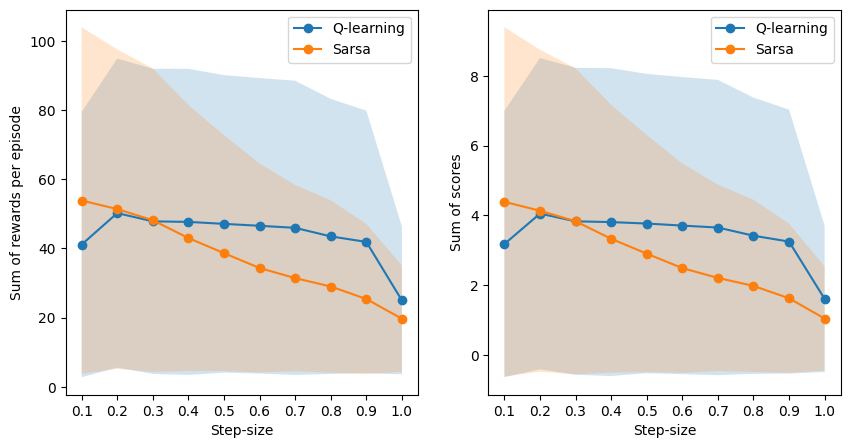

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for algorithm in ["Q-learning", "Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, alpha)]) for alpha in alphas])
    algorithm_stds = np.array([np.std(all_reward_sums[(algorithm, alpha)]) for alpha in alphas])
    ax1.plot(alphas, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    ax1.fill_between(alphas, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

ax1.legend()
ax1.set_xlabel("Step-size")
ax1.set_ylabel("Sum of rewards per episode", rotation=90)
ax1.set_xticks(alphas)

for algorithm in ["Q-learning", "Sarsa"]:
    algorithm_means = np.array([np.mean(all_scores_sums[(algorithm, alpha)]) for alpha in alphas])
    algorithm_stds = np.array([np.std(all_scores_sums[(algorithm, alpha)]) for alpha in alphas])
    ax2.plot(alphas, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    ax2.fill_between(alphas, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

ax2.legend()
ax2.set_xlabel("Step-size")
ax2.set_ylabel("Sum of scores", rotation=90)
ax2.set_xticks(alphas)

plt.show()

From above we can see that the best step-size is 0.2 for both the agents


## Epsilon

In [63]:
epsilons = np.linspace(0.1,1.0,10)
num_episodes = 10000
q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.
if __name__ == '__main__':
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    
    for algorithm in ["Q-learning", "Sarsa"]:
        for epsilon in epsilons:
            reward_for_step = 0
            params =  params ={'epsilon': epsilon, 'alpha' : 0.2, 'gamma':0.95, 'epsilon_decay' : 0.999, 'alpha_decay' : 0.9999}
            print("Epsilon = " , epsilon )
            reward_for_step, score_for_step = train_agent(algorithm, params)
                
            all_reward_sums[(algorithm, epsilon)] = []    
            all_reward_sums[(algorithm, epsilon)].append(reward_for_step)
            all_scores_sums[(algorithm, epsilon)] = []    
            all_scores_sums[(algorithm, epsilon)].append(score_for_step)


Epsilon =  0.1


 10%|█         | 1049/10000 [00:03<00:44, 202.71it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2031/10000 [00:09<01:06, 119.97it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3013/10000 [00:17<01:04, 108.07it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4022/10000 [00:25<00:45, 130.53it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5023/10000 [00:34<00:36, 135.05it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6015/10000 [00:42<00:35, 112.43it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7032/10000 [00:51<00:26, 110.79it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8029/10000 [00:59<00:12, 162.20it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9040/10000 [01:06<00:05, 191.34it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:14<00:00, 133.59it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.2


 11%|█         | 1054/10000 [00:03<00:33, 264.28it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2050/10000 [00:07<00:31, 250.27it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3039/10000 [00:11<00:26, 258.42it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4060/10000 [00:15<00:26, 221.10it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5050/10000 [00:18<00:19, 257.89it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6018/10000 [00:22<00:20, 197.48it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7011/10000 [00:26<00:10, 277.52it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8072/10000 [00:30<00:07, 254.88it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9034/10000 [00:33<00:03, 249.37it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:38<00:00, 263.06it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.30000000000000004


 11%|█         | 1075/10000 [00:02<00:18, 474.10it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2032/10000 [00:04<00:22, 358.63it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3088/10000 [00:07<00:17, 405.97it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4055/10000 [00:09<00:16, 360.84it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5046/10000 [00:12<00:14, 333.80it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6042/10000 [00:14<00:11, 358.55it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7063/10000 [00:17<00:06, 463.47it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8062/10000 [00:19<00:04, 473.76it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9088/10000 [00:22<00:02, 448.77it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:24<00:00, 400.07it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.4


 10%|█         | 1028/10000 [00:01<00:12, 698.16it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 21%|██        | 2063/10000 [00:03<00:15, 496.17it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3061/10000 [00:05<00:12, 566.52it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4105/10000 [00:06<00:08, 728.91it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 52%|█████▏    | 5170/10000 [00:08<00:08, 577.57it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████▏   | 6149/10000 [00:09<00:05, 677.52it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7080/10000 [00:11<00:04, 612.00it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8093/10000 [00:13<00:03, 525.59it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9109/10000 [00:15<00:01, 555.55it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:16<00:00, 592.06it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.5


 11%|█▏        | 1129/10000 [00:01<00:10, 843.09it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 21%|██        | 2110/10000 [00:02<00:11, 670.62it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 32%|███▏      | 3224/10000 [00:04<00:09, 708.94it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4098/10000 [00:05<00:07, 759.23it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5088/10000 [00:06<00:06, 814.42it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████    | 6121/10000 [00:08<00:06, 619.10it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7103/10000 [00:09<00:04, 675.65it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 82%|████████▏ | 8196/10000 [00:11<00:02, 798.76it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9069/10000 [00:12<00:01, 720.00it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:13<00:00, 746.43it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.6


 11%|█▏        | 1149/10000 [00:01<00:08, 995.72it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 21%|██▏       | 2126/10000 [00:02<00:06, 1186.31it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 32%|███▏      | 3217/10000 [00:03<00:05, 1240.66it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4124/10000 [00:03<00:06, 949.62it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5107/10000 [00:04<00:04, 1027.90it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████▏   | 6127/10000 [00:05<00:04, 958.48it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 72%|███████▏  | 7219/10000 [00:07<00:02, 973.37it/s] 

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████  | 8088/10000 [00:08<00:02, 779.22it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9087/10000 [00:09<00:01, 810.55it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:10<00:00, 936.72it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.7000000000000001


 12%|█▏        | 1179/10000 [00:01<00:06, 1343.21it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 22%|██▏       | 2164/10000 [00:01<00:05, 1383.11it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 32%|███▏      | 3170/10000 [00:02<00:05, 1333.37it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 43%|████▎     | 4302/10000 [00:03<00:04, 1328.28it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 52%|█████▏    | 5224/10000 [00:04<00:04, 1182.05it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 62%|██████▏   | 6208/10000 [00:04<00:02, 1389.26it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 73%|███████▎  | 7281/10000 [00:05<00:02, 1246.92it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 81%|████████▏ | 8131/10000 [00:06<00:01, 1401.35it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 92%|█████████▏| 9185/10000 [00:07<00:00, 1471.61it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:07<00:00, 1309.27it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.8


 14%|█▍        | 1377/10000 [00:00<00:05, 1507.86it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 25%|██▌       | 2519/10000 [00:01<00:04, 1625.14it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 32%|███▏      | 3220/10000 [00:01<00:03, 1733.59it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 42%|████▏     | 4187/10000 [00:02<00:04, 1451.52it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 52%|█████▏    | 5202/10000 [00:03<00:04, 1124.25it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████    | 6118/10000 [00:04<00:03, 1113.63it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 71%|███████   | 7107/10000 [00:05<00:02, 973.66it/s] 

	Episode 7000/10000 complete for Q-learning algorithm


 83%|████████▎ | 8293/10000 [00:06<00:01, 1280.29it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 93%|█████████▎| 9252/10000 [00:07<00:00, 1553.87it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:07<00:00, 1341.27it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.9


 12%|█▏        | 1210/10000 [00:00<00:04, 1921.02it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 24%|██▍       | 2390/10000 [00:01<00:03, 1966.28it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 35%|███▌      | 3525/10000 [00:01<00:03, 1823.68it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 43%|████▎     | 4293/10000 [00:02<00:03, 1813.52it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 52%|█████▏    | 5241/10000 [00:02<00:02, 1880.24it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 62%|██████▏   | 6194/10000 [00:03<00:02, 1769.80it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 73%|███████▎  | 7349/10000 [00:03<00:01, 1909.69it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 83%|████████▎ | 8341/10000 [00:04<00:00, 1941.15it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 93%|█████████▎| 9299/10000 [00:04<00:00, 1724.95it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:05<00:00, 1856.56it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  1.0


 13%|█▎        | 1319/10000 [00:00<00:03, 2277.52it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 22%|██▏       | 2234/10000 [00:01<00:03, 2254.49it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 34%|███▍      | 3380/10000 [00:01<00:02, 2228.49it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 43%|████▎     | 4308/10000 [00:01<00:02, 2221.17it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 54%|█████▍    | 5436/10000 [00:02<00:02, 2184.01it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 63%|██████▎   | 6349/10000 [00:02<00:01, 2234.59it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 72%|███████▏  | 7224/10000 [00:03<00:01, 1780.93it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 82%|████████▏ | 8190/10000 [00:04<00:01, 1403.83it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 92%|█████████▏| 9162/10000 [00:04<00:00, 1322.38it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:05<00:00, 1841.30it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Epsilon =  0.1


 10%|█         | 1014/10000 [00:11<01:58, 75.78it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2003/10000 [00:25<01:41, 78.62it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3022/10000 [00:39<01:17, 90.13it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4017/10000 [00:52<01:03, 94.60it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5018/10000 [01:05<00:57, 86.80it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6022/10000 [01:17<00:38, 103.66it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7007/10000 [01:30<00:39, 76.51it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8012/10000 [01:43<00:20, 96.18it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9001/10000 [01:55<00:08, 118.14it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [02:08<00:00, 77.89it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  0.2


 10%|█         | 1027/10000 [00:06<01:03, 141.77it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2028/10000 [00:13<00:53, 147.77it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3015/10000 [00:19<00:52, 134.15it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4033/10000 [00:26<00:38, 156.89it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5029/10000 [00:33<00:33, 147.43it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6016/10000 [00:40<00:27, 146.85it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7018/10000 [00:47<00:25, 117.13it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8035/10000 [00:54<00:12, 153.21it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9024/10000 [01:01<00:08, 120.58it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:07<00:00, 148.39it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  0.30000000000000004


 11%|█         | 1065/10000 [00:04<00:35, 251.77it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2030/10000 [00:09<00:38, 204.47it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3033/10000 [00:13<00:29, 233.27it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4048/10000 [00:17<00:21, 273.85it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5043/10000 [00:22<00:22, 219.05it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6028/10000 [00:25<00:14, 266.47it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 71%|███████   | 7067/10000 [00:30<00:08, 326.58it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8026/10000 [00:34<00:09, 213.53it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 91%|█████████ | 9053/10000 [00:39<00:03, 243.06it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:42<00:00, 233.30it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  0.4


 11%|█         | 1081/10000 [00:03<00:22, 398.18it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2041/10000 [00:06<00:27, 293.41it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 31%|███       | 3056/10000 [00:09<00:19, 347.85it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 41%|████      | 4096/10000 [00:12<00:20, 284.89it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████     | 5053/10000 [00:15<00:17, 278.97it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6037/10000 [00:18<00:15, 261.04it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 71%|███████   | 7069/10000 [00:22<00:08, 329.06it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████  | 8085/10000 [00:25<00:06, 312.44it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 91%|█████████ | 9052/10000 [00:28<00:02, 337.91it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:31<00:00, 319.22it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  0.5


 10%|█         | 1042/10000 [00:03<00:31, 285.46it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 21%|██        | 2080/10000 [00:06<00:18, 423.82it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3048/10000 [00:08<00:19, 361.11it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 41%|████      | 4083/10000 [00:11<00:13, 438.53it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████     | 5062/10000 [00:13<00:11, 413.33it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6040/10000 [00:16<00:11, 334.88it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 71%|███████   | 7089/10000 [00:18<00:05, 505.92it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████  | 8116/10000 [00:21<00:03, 561.21it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9045/10000 [00:23<00:01, 484.62it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:25<00:00, 392.27it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  0.6


 11%|█         | 1072/10000 [00:01<00:15, 587.50it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2049/10000 [00:03<00:16, 468.15it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 31%|███       | 3068/10000 [00:06<00:17, 403.26it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 41%|████      | 4082/10000 [00:08<00:11, 532.86it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████     | 5102/10000 [00:09<00:07, 642.87it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 61%|██████    | 6080/10000 [00:11<00:06, 592.32it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 71%|███████   | 7065/10000 [00:13<00:05, 568.26it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████▏ | 8132/10000 [00:15<00:02, 634.14it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 91%|█████████ | 9062/10000 [00:17<00:02, 442.14it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:19<00:00, 519.04it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  0.7000000000000001


 11%|█         | 1122/10000 [00:01<00:13, 651.44it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 21%|██        | 2085/10000 [00:03<00:11, 701.24it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 31%|███       | 3094/10000 [00:04<00:07, 882.91it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 41%|████      | 4124/10000 [00:05<00:08, 731.65it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████     | 5093/10000 [00:07<00:07, 633.70it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 61%|██████    | 6104/10000 [00:08<00:06, 636.68it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 71%|███████   | 7107/10000 [00:09<00:04, 712.52it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████  | 8077/10000 [00:11<00:03, 568.89it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 91%|█████████ | 9096/10000 [00:13<00:01, 593.63it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:14<00:00, 672.99it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  0.8


 12%|█▏        | 1249/10000 [00:01<00:09, 902.86it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 21%|██▏       | 2131/10000 [00:02<00:09, 829.06it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 32%|███▏      | 3156/10000 [00:03<00:06, 1017.28it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 41%|████▏     | 4145/10000 [00:04<00:06, 972.85it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 51%|█████▏    | 5139/10000 [00:05<00:04, 1031.96it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 62%|██████▏   | 6186/10000 [00:06<00:03, 965.00it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 71%|███████▏  | 7137/10000 [00:07<00:03, 934.82it/s] 

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████  | 8111/10000 [00:08<00:01, 1062.01it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 91%|█████████ | 9064/10000 [00:09<00:01, 740.45it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:11<00:00, 898.41it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  0.9


 12%|█▏        | 1160/10000 [00:01<00:10, 852.84it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 23%|██▎       | 2300/10000 [00:02<00:06, 1156.87it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 33%|███▎      | 3270/10000 [00:03<00:04, 1389.97it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 42%|████▏     | 4230/10000 [00:03<00:04, 1251.30it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 53%|█████▎    | 5343/10000 [00:04<00:03, 1323.34it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 63%|██████▎   | 6330/10000 [00:05<00:02, 1228.67it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 73%|███████▎  | 7310/10000 [00:06<00:02, 1188.49it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 84%|████████▎ | 8351/10000 [00:07<00:01, 1176.83it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 92%|█████████▏| 9236/10000 [00:07<00:00, 1158.03it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:08<00:00, 1169.27it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Epsilon =  1.0


 14%|█▍        | 1379/10000 [00:00<00:04, 1903.67it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 24%|██▍       | 2391/10000 [00:01<00:03, 1924.14it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 34%|███▎      | 3368/10000 [00:01<00:03, 1917.10it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 43%|████▎     | 4338/10000 [00:02<00:02, 1934.78it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 53%|█████▎    | 5314/10000 [00:02<00:02, 1889.81it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 63%|██████▎   | 6260/10000 [00:03<00:02, 1829.64it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 72%|███████▏  | 7173/10000 [00:04<00:02, 1265.45it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 81%|████████▏ | 8139/10000 [00:04<00:01, 1173.19it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 92%|█████████▏| 9231/10000 [00:05<00:00, 1223.83it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [00:06<00:00, 1540.38it/s]

	Episode 10000/10000 complete for Sarsa algorithm


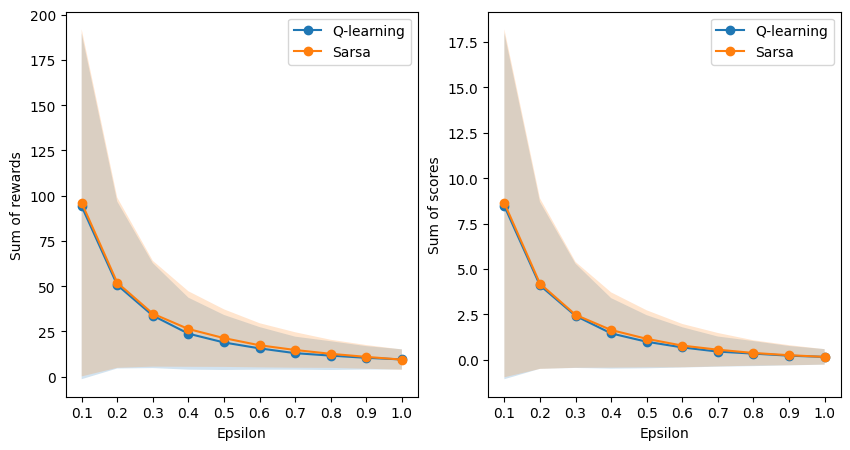

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for algorithm in ["Q-learning", "Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, epsilon)]) for epsilon in epsilons])
    algorithm_stds = np.array([np.std(all_reward_sums[(algorithm, epsilon)]) for epsilon in epsilons])
    ax1.plot(epsilons, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    ax1.fill_between(epsilons, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

ax1.legend()
ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Sum of rewards", rotation=90)
ax1.set_xticks(epsilons)

for algorithm in ["Q-learning", "Sarsa"]:
    algorithm_means = np.array([np.mean(all_scores_sums[(algorithm, epsilon)]) for epsilon in epsilons])
    algorithm_stds = np.array([np.std(all_scores_sums[(algorithm, epsilon)]) for epsilon in epsilons])
    ax2.plot(epsilons, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    ax2.fill_between(epsilons, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

ax2.legend()
ax2.set_xlabel("Epsilon")
ax2.set_ylabel("Sum of scores", rotation=90)
ax2.set_xticks(epsilons)

plt.show()


From above we can see that the best epsilon is 0.1 for both the agents


## Gamma

In [94]:
gammas = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]
num_episodes = 10000
all_reward_sums = {}
all_scores_sums = {}
q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.

if __name__ == '__main__':
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    
    for algorithm in ["Q-learning", "Sarsa"]:
        for gamma in gammas:
            reward_for_step = 0
            params =  {'epsilon': 0.1, 'alpha': 0.2, 'gamma': gamma, 'epsilon_decay': 0.999, 'alpha_decay': 0.9999}
            print("Gamma = ", gamma)
            reward_for_step, score_for_step = train_agent(algorithm, params)
                
            all_reward_sums[(algorithm, gamma)] = []    
            all_reward_sums[(algorithm, gamma)].append(reward_for_step)
            all_scores_sums[(algorithm, gamma)] = []    
            all_scores_sums[(algorithm, gamma)].append(score_for_step)


Gamma =  1.0


 10%|█         | 1041/10000 [00:02<00:29, 307.14it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2034/10000 [00:06<00:31, 249.29it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3007/10000 [00:10<00:27, 250.57it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4045/10000 [00:15<00:26, 222.17it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 51%|█████     | 5061/10000 [00:19<00:20, 246.36it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 61%|██████    | 6056/10000 [00:22<00:12, 327.91it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7030/10000 [00:26<00:10, 276.72it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8021/10000 [00:30<00:09, 207.95it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 91%|█████████ | 9062/10000 [00:34<00:03, 277.08it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:37<00:00, 266.72it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.95


 11%|█         | 1095/10000 [00:02<00:16, 532.29it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2030/10000 [00:04<00:17, 452.28it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 31%|███       | 3077/10000 [00:07<00:17, 400.47it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 41%|████      | 4085/10000 [00:10<00:14, 417.58it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5033/10000 [00:15<00:34, 145.68it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6036/10000 [00:23<00:27, 144.80it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7025/10000 [00:30<00:19, 156.38it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8022/10000 [00:38<00:13, 150.85it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9042/10000 [00:44<00:04, 198.27it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [00:53<00:00, 186.13it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.9


 10%|█         | 1021/10000 [00:03<00:40, 223.72it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2020/10000 [00:11<01:19, 100.63it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3023/10000 [00:18<00:47, 147.40it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4010/10000 [00:26<01:22, 72.36it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5001/10000 [00:33<00:35, 139.10it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6014/10000 [00:41<00:35, 113.61it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7007/10000 [00:48<00:21, 140.65it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8020/10000 [00:55<00:16, 119.91it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9024/10000 [01:03<00:07, 129.65it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:11<00:00, 140.11it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.85


 10%|█         | 1015/10000 [00:04<01:12, 123.62it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2027/10000 [00:12<00:49, 160.53it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3021/10000 [00:20<00:57, 120.97it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4018/10000 [00:28<00:44, 133.89it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5018/10000 [00:36<00:34, 145.86it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6023/10000 [00:43<00:24, 165.60it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7023/10000 [00:51<00:26, 114.22it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8009/10000 [00:59<00:18, 108.43it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9019/10000 [01:07<00:08, 111.06it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:14<00:00, 133.69it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.8


 10%|█         | 1021/10000 [00:05<01:09, 128.88it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2024/10000 [00:13<00:57, 138.59it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3016/10000 [00:20<01:01, 112.75it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4036/10000 [00:29<00:47, 125.54it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5021/10000 [00:36<00:44, 112.74it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6032/10000 [00:45<00:31, 126.88it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7014/10000 [00:53<00:26, 111.37it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8023/10000 [01:01<00:18, 109.68it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9024/10000 [01:08<00:08, 117.25it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:15<00:00, 131.66it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.75


 10%|█         | 1021/10000 [00:07<01:14, 121.28it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2030/10000 [00:14<00:58, 135.56it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3009/10000 [00:22<00:44, 157.20it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4021/10000 [00:29<00:34, 172.87it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5044/10000 [00:37<00:36, 137.39it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6019/10000 [00:44<00:33, 120.59it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7024/10000 [00:52<00:20, 148.01it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8017/10000 [00:59<00:18, 106.18it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9023/10000 [01:08<00:08, 113.46it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:16<00:00, 131.01it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.7


 10%|█         | 1017/10000 [00:05<01:04, 139.22it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2018/10000 [00:12<01:05, 121.25it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3019/10000 [00:20<00:48, 143.69it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4010/10000 [00:27<00:56, 105.33it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5018/10000 [00:34<00:42, 117.96it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6027/10000 [00:42<00:29, 133.51it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7020/10000 [00:50<00:26, 114.26it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8019/10000 [00:58<00:14, 133.65it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9019/10000 [01:06<00:07, 125.64it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:14<00:00, 134.53it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.65


 10%|█         | 1016/10000 [00:06<01:19, 113.31it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2028/10000 [00:14<00:50, 157.70it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3019/10000 [00:21<00:57, 121.78it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4022/10000 [00:28<00:37, 161.18it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5021/10000 [00:36<00:38, 129.42it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6039/10000 [00:43<00:25, 156.38it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7030/10000 [00:52<00:22, 132.29it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8027/10000 [00:59<00:15, 127.55it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9018/10000 [01:08<00:06, 141.10it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:16<00:00, 131.26it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.6


 10%|█         | 1024/10000 [00:06<01:08, 131.29it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2030/10000 [00:13<00:54, 145.30it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3019/10000 [00:21<00:44, 156.30it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4011/10000 [00:29<00:57, 104.64it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5021/10000 [00:37<00:45, 110.36it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6019/10000 [00:44<00:34, 116.25it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7021/10000 [00:51<00:24, 120.48it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8031/10000 [01:00<00:13, 146.60it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9029/10000 [01:07<00:06, 151.81it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:15<00:00, 132.86it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.55


 10%|█         | 1018/10000 [00:07<01:14, 120.26it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2023/10000 [00:15<01:13, 108.17it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3016/10000 [00:23<01:00, 115.34it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4031/10000 [00:30<00:40, 147.44it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5007/10000 [00:38<00:37, 133.65it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6026/10000 [00:46<00:24, 164.51it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7012/10000 [00:54<00:26, 113.27it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8019/10000 [01:02<00:13, 143.22it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9038/10000 [01:10<00:07, 121.48it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:17<00:00, 128.61it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  0.5


 10%|█         | 1041/10000 [00:06<01:02, 143.47it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2011/10000 [00:14<01:06, 120.75it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3036/10000 [00:21<00:42, 163.96it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4017/10000 [00:29<00:54, 109.94it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5030/10000 [00:37<00:31, 156.22it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6043/10000 [00:45<00:32, 122.34it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7017/10000 [00:53<00:22, 134.11it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8020/10000 [01:01<00:18, 108.79it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9003/10000 [01:09<00:09, 104.13it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:17<00:00, 129.15it/s]


	Episode 10000/10000 complete for Q-learning algorithm
Gamma =  1.0


 10%|█         | 1010/10000 [00:13<01:51, 80.98it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2018/10000 [00:28<01:35, 83.88it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3004/10000 [00:41<01:30, 77.21it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4013/10000 [00:53<01:06, 90.50it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5009/10000 [01:06<01:03, 78.87it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6007/10000 [01:19<01:00, 65.87it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7013/10000 [01:31<00:32, 92.01it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8018/10000 [01:43<00:22, 88.92it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9008/10000 [01:57<00:17, 58.28it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [02:08<00:00, 77.82it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.95


 10%|█         | 1022/10000 [00:05<00:52, 171.03it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2024/10000 [00:11<00:57, 139.42it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3012/10000 [00:23<01:33, 74.68it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4011/10000 [00:36<01:36, 61.84it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5018/10000 [00:49<00:48, 102.58it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6014/10000 [01:02<00:51, 77.10it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7016/10000 [01:16<00:31, 93.60it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8008/10000 [01:30<00:31, 63.80it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9009/10000 [01:43<00:15, 63.37it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:56<00:00, 86.08it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.9


 10%|█         | 1008/10000 [00:08<02:21, 63.33it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2008/10000 [00:21<01:19, 100.32it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3008/10000 [00:32<01:08, 102.44it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4012/10000 [00:46<01:16, 78.77it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5015/10000 [00:59<01:06, 74.45it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6003/10000 [01:12<00:43, 92.39it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7024/10000 [01:25<00:47, 62.62it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8008/10000 [01:39<00:33, 58.95it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9006/10000 [01:52<00:16, 59.40it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [02:06<00:00, 79.30it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.85


 10%|█         | 1007/10000 [00:09<01:51, 81.00it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2014/10000 [00:21<01:33, 85.68it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3014/10000 [00:34<01:14, 93.76it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4020/10000 [00:47<01:33, 64.27it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5015/10000 [01:00<00:49, 101.26it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6004/10000 [01:13<00:37, 107.14it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7003/10000 [01:27<00:37, 80.01it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8002/10000 [01:40<00:29, 67.74it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9010/10000 [01:54<00:13, 72.22it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [02:07<00:00, 78.61it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.8


 10%|█         | 1017/10000 [00:10<01:55, 78.03it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2014/10000 [00:22<01:38, 81.08it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3010/10000 [00:34<01:11, 98.00it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4012/10000 [00:48<01:11, 83.94it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5013/10000 [01:00<00:52, 95.59it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6020/10000 [01:13<00:39, 100.53it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7009/10000 [01:26<00:29, 103.06it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8031/10000 [01:40<00:19, 101.74it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9018/10000 [01:53<00:12, 77.13it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [02:05<00:00, 79.70it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.75


 10%|█         | 1015/10000 [00:09<01:54, 78.21it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2006/10000 [00:21<01:37, 81.94it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3014/10000 [00:35<01:51, 62.82it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4012/10000 [00:47<00:57, 104.36it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5008/10000 [00:59<00:59, 84.43it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6011/10000 [01:13<00:55, 72.22it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7013/10000 [01:26<00:35, 84.24it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8019/10000 [01:38<00:25, 77.94it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9012/10000 [01:49<00:11, 87.06it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [02:01<00:00, 82.18it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.7


 10%|█         | 1016/10000 [00:10<01:14, 120.79it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2000/10000 [00:22<01:00, 132.33it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3014/10000 [00:34<01:20, 86.28it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4014/10000 [00:47<01:15, 79.12it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5005/10000 [00:58<01:16, 65.71it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6014/10000 [01:12<00:52, 75.63it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7012/10000 [01:25<00:44, 66.42it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8014/10000 [01:37<00:25, 79.41it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9016/10000 [01:50<00:11, 82.63it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [02:02<00:00, 81.46it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.65


 10%|█         | 1019/10000 [00:10<01:40, 89.02it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2013/10000 [00:21<01:50, 72.03it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3011/10000 [00:33<01:35, 73.48it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4011/10000 [00:45<01:33, 64.34it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5018/10000 [00:57<00:54, 91.42it/s] 

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6020/10000 [01:08<00:40, 97.42it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7034/10000 [01:20<00:34, 85.31it/s] 

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8012/10000 [01:32<00:27, 71.08it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9014/10000 [01:44<00:13, 70.90it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:57<00:00, 85.01it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.6


 10%|█         | 1017/10000 [00:09<01:28, 101.70it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2022/10000 [00:22<01:18, 101.07it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3006/10000 [00:33<01:31, 76.27it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4017/10000 [00:45<01:02, 95.43it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5012/10000 [00:56<01:06, 74.89it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6009/10000 [01:07<00:47, 83.43it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7013/10000 [01:18<00:24, 121.06it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8011/10000 [01:31<00:23, 85.77it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9006/10000 [01:43<00:10, 97.77it/s] 

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:55<00:00, 86.31it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.55


 10%|█         | 1018/10000 [00:09<01:50, 81.20it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2007/10000 [00:20<01:33, 85.60it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3013/10000 [00:32<01:48, 64.52it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4026/10000 [00:44<00:46, 128.72it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5004/10000 [00:57<01:13, 67.83it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6020/10000 [01:09<00:36, 110.15it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7003/10000 [01:20<00:26, 111.10it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8022/10000 [01:32<00:20, 97.52it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9013/10000 [01:43<00:10, 94.94it/s] 

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:54<00:00, 87.21it/s]


	Episode 10000/10000 complete for Sarsa algorithm
Gamma =  0.5


 10%|█         | 1020/10000 [00:09<01:29, 100.83it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2010/10000 [00:19<01:21, 98.15it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3020/10000 [00:28<01:00, 115.45it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4017/10000 [00:40<00:52, 114.39it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5011/10000 [00:50<00:46, 106.17it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6008/10000 [01:02<00:51, 77.25it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7008/10000 [01:14<00:37, 80.37it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8020/10000 [01:25<00:22, 89.89it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9013/10000 [01:36<00:10, 91.99it/s] 

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [01:48<00:00, 92.41it/s]

	Episode 10000/10000 complete for Sarsa algorithm


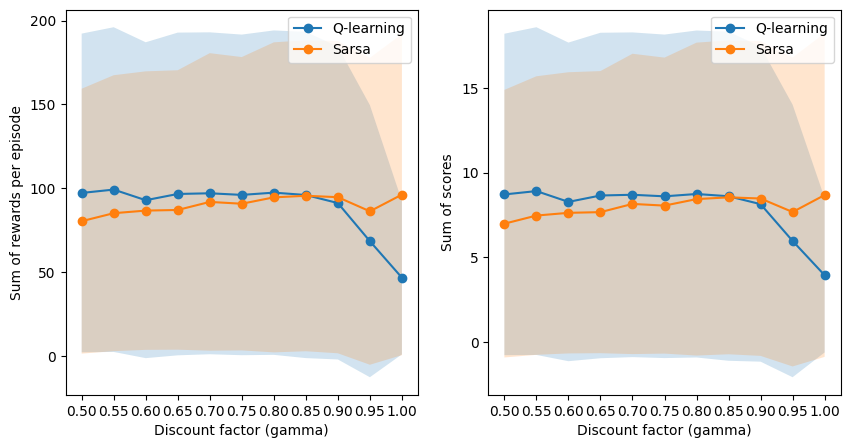

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for algorithm in ["Q-learning", "Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, gamma)]) for gamma in gammas])
    algorithm_stds = np.array([np.std(all_reward_sums[(algorithm, gamma)]) for gamma in gammas])
    ax1.plot(gammas, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    ax1.fill_between(gammas, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

ax1.legend()
ax1.set_xlabel("Discount factor (gamma)")
ax1.set_ylabel("Sum of rewards per episode", rotation=90)
ax1.set_xticks(gammas)

for algorithm in ["Q-learning", "Sarsa"]:
    algorithm_means = np.array([np.mean(all_scores_sums[(algorithm, gamma)]) for gamma in gammas])
    algorithm_stds = np.array([np.std(all_scores_sums[(algorithm, gamma)]) for gamma in gammas])
    ax2.plot(gammas, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    ax2.fill_between(gammas, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

ax2.legend()
ax2.set_xlabel("Discount factor (gamma)")
ax2.set_ylabel("Sum of scores", rotation=90)
ax2.set_xticks(gammas)

plt.show()


From above we can see that the best gamma is 0.85 for both the agents


# Final Results and comparisons

 10%|█         | 1025/10000 [00:03<00:47, 188.79it/s]

	Episode 1000/10000 complete for Q-learning algorithm


 20%|██        | 2020/10000 [00:09<01:00, 132.89it/s]

	Episode 2000/10000 complete for Q-learning algorithm


 30%|███       | 3022/10000 [00:17<00:47, 145.71it/s]

	Episode 3000/10000 complete for Q-learning algorithm


 40%|████      | 4034/10000 [00:24<00:32, 182.07it/s]

	Episode 4000/10000 complete for Q-learning algorithm


 50%|█████     | 5031/10000 [00:33<00:44, 111.62it/s]

	Episode 5000/10000 complete for Q-learning algorithm


 60%|██████    | 6022/10000 [00:40<00:38, 103.93it/s]

	Episode 6000/10000 complete for Q-learning algorithm


 70%|███████   | 7035/10000 [00:49<00:19, 153.07it/s]

	Episode 7000/10000 complete for Q-learning algorithm


 80%|████████  | 8016/10000 [00:56<00:18, 106.57it/s]

	Episode 8000/10000 complete for Q-learning algorithm


 90%|█████████ | 9021/10000 [01:05<00:06, 160.38it/s]

	Episode 9000/10000 complete for Q-learning algorithm


100%|██████████| 10000/10000 [01:13<00:00, 136.60it/s]


	Episode 10000/10000 complete for Q-learning algorithm


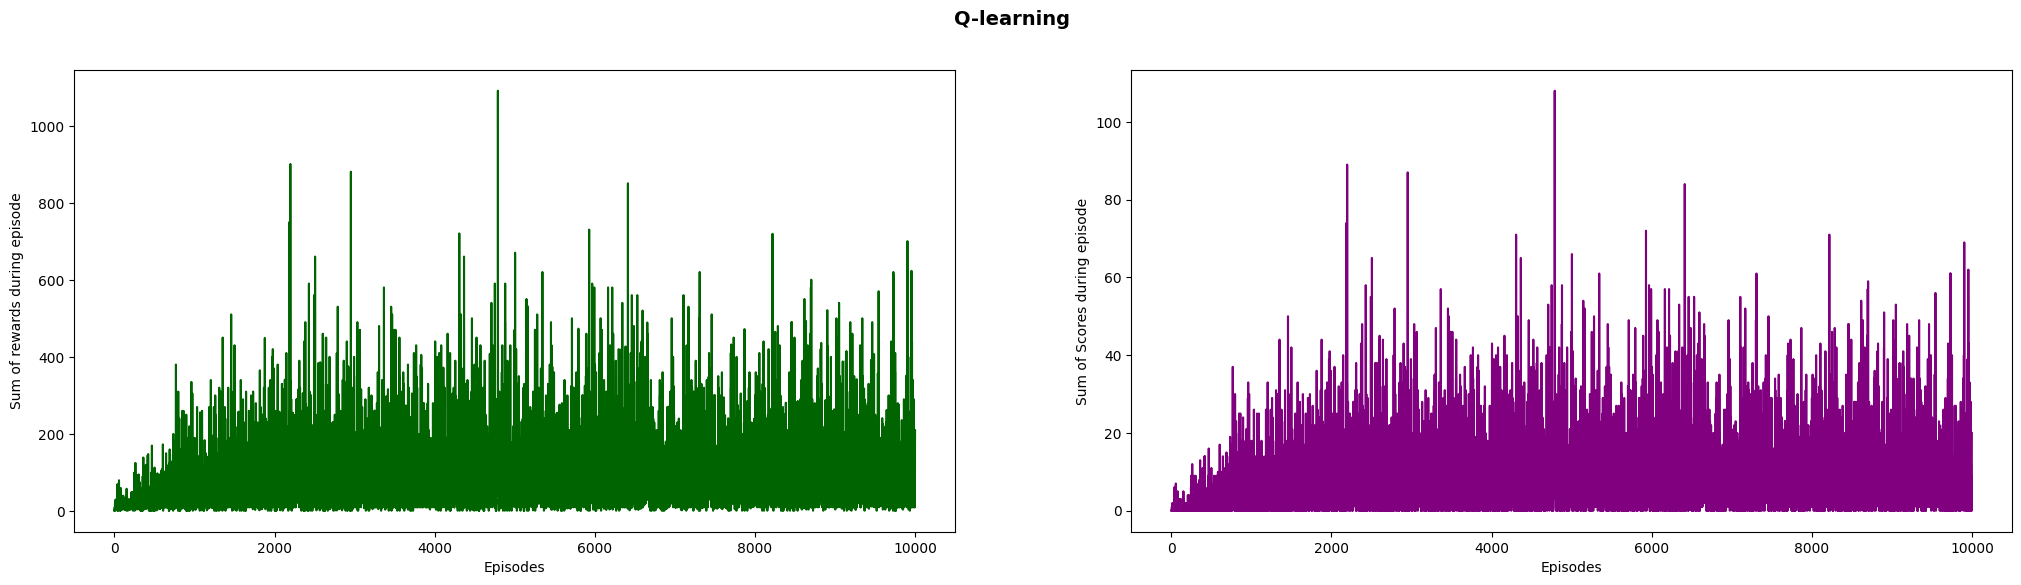

 10%|█         | 1006/10000 [00:11<03:05, 48.46it/s]

	Episode 1000/10000 complete for Sarsa algorithm


 20%|██        | 2009/10000 [00:23<01:40, 79.36it/s]

	Episode 2000/10000 complete for Sarsa algorithm


 30%|███       | 3019/10000 [00:36<01:27, 79.41it/s]

	Episode 3000/10000 complete for Sarsa algorithm


 40%|████      | 4021/10000 [00:48<01:34, 63.07it/s]

	Episode 4000/10000 complete for Sarsa algorithm


 50%|█████     | 5010/10000 [01:01<01:04, 77.67it/s]

	Episode 5000/10000 complete for Sarsa algorithm


 60%|██████    | 6017/10000 [01:14<00:53, 74.41it/s]

	Episode 6000/10000 complete for Sarsa algorithm


 70%|███████   | 7001/10000 [01:27<00:34, 86.34it/s]

	Episode 7000/10000 complete for Sarsa algorithm


 80%|████████  | 8009/10000 [01:40<00:21, 91.55it/s]

	Episode 8000/10000 complete for Sarsa algorithm


 90%|█████████ | 9002/10000 [01:53<00:11, 88.40it/s]

	Episode 9000/10000 complete for Sarsa algorithm


100%|██████████| 10000/10000 [02:07<00:00, 78.46it/s]


	Episode 10000/10000 complete for Sarsa algorithm


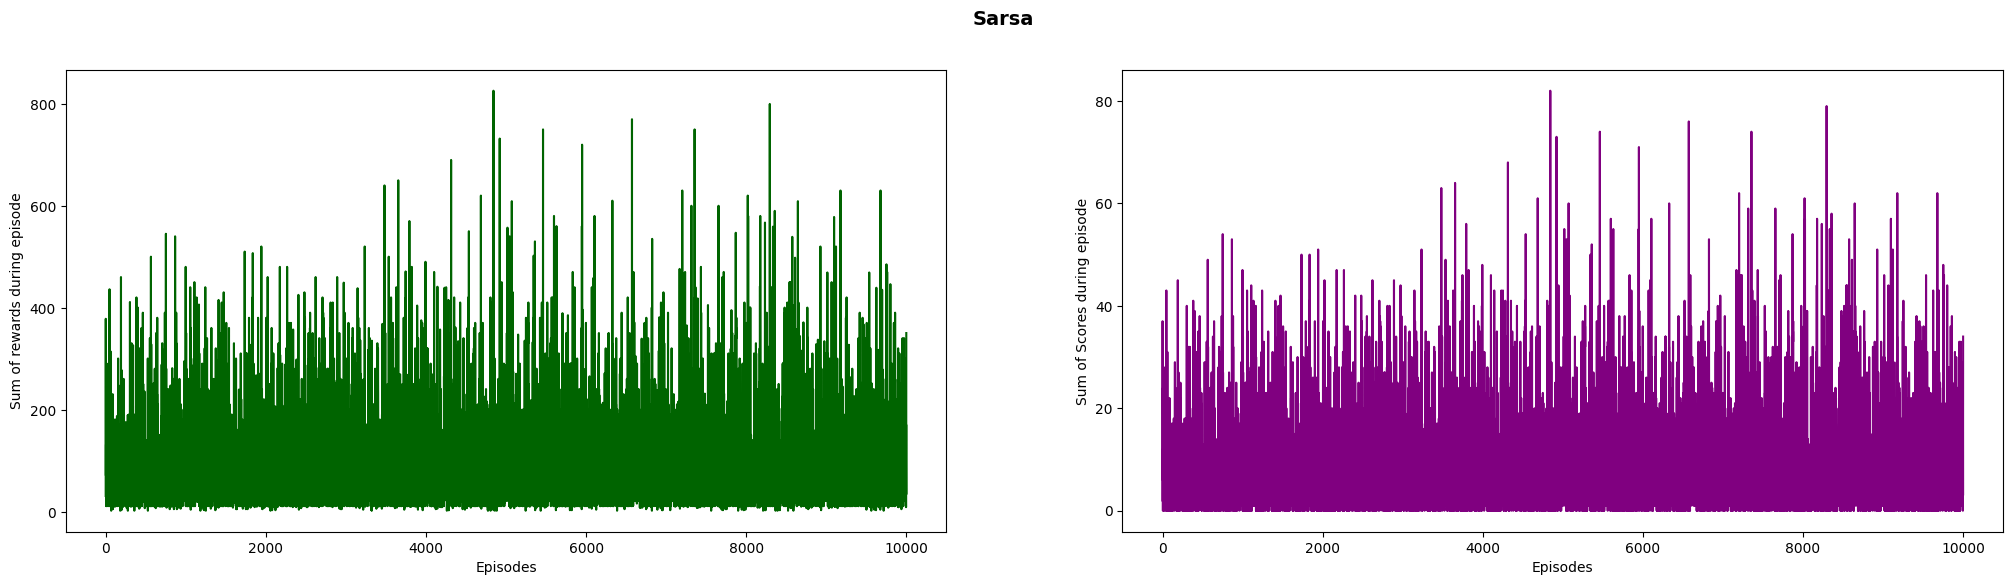

 17%|█▋        | 1735/10000 [00:00<00:01, 4456.38it/s]

	Episode 1000/10000 complete for RandomAgent algorithm


 26%|██▌       | 2610/10000 [00:00<00:01, 4268.13it/s]

	Episode 2000/10000 complete for RandomAgent algorithm


 35%|███▌      | 3502/10000 [00:00<00:01, 4305.05it/s]

	Episode 3000/10000 complete for RandomAgent algorithm


 49%|████▊     | 4863/10000 [00:01<00:01, 4478.56it/s]

	Episode 4000/10000 complete for RandomAgent algorithm


 57%|█████▋    | 5736/10000 [00:01<00:01, 4053.49it/s]

	Episode 5000/10000 complete for RandomAgent algorithm


 66%|██████▌   | 6622/10000 [00:01<00:00, 4249.14it/s]

	Episode 6000/10000 complete for RandomAgent algorithm


 75%|███████▍  | 7476/10000 [00:01<00:00, 4231.65it/s]

	Episode 7000/10000 complete for RandomAgent algorithm


 88%|████████▊ | 8815/10000 [00:02<00:00, 4357.01it/s]

	Episode 8000/10000 complete for RandomAgent algorithm


 97%|█████████▋| 9720/10000 [00:02<00:00, 4430.05it/s]

	Episode 9000/10000 complete for RandomAgent algorithm


100%|██████████| 10000/10000 [00:02<00:00, 4239.67it/s]


	Episode 10000/10000 complete for RandomAgent algorithm


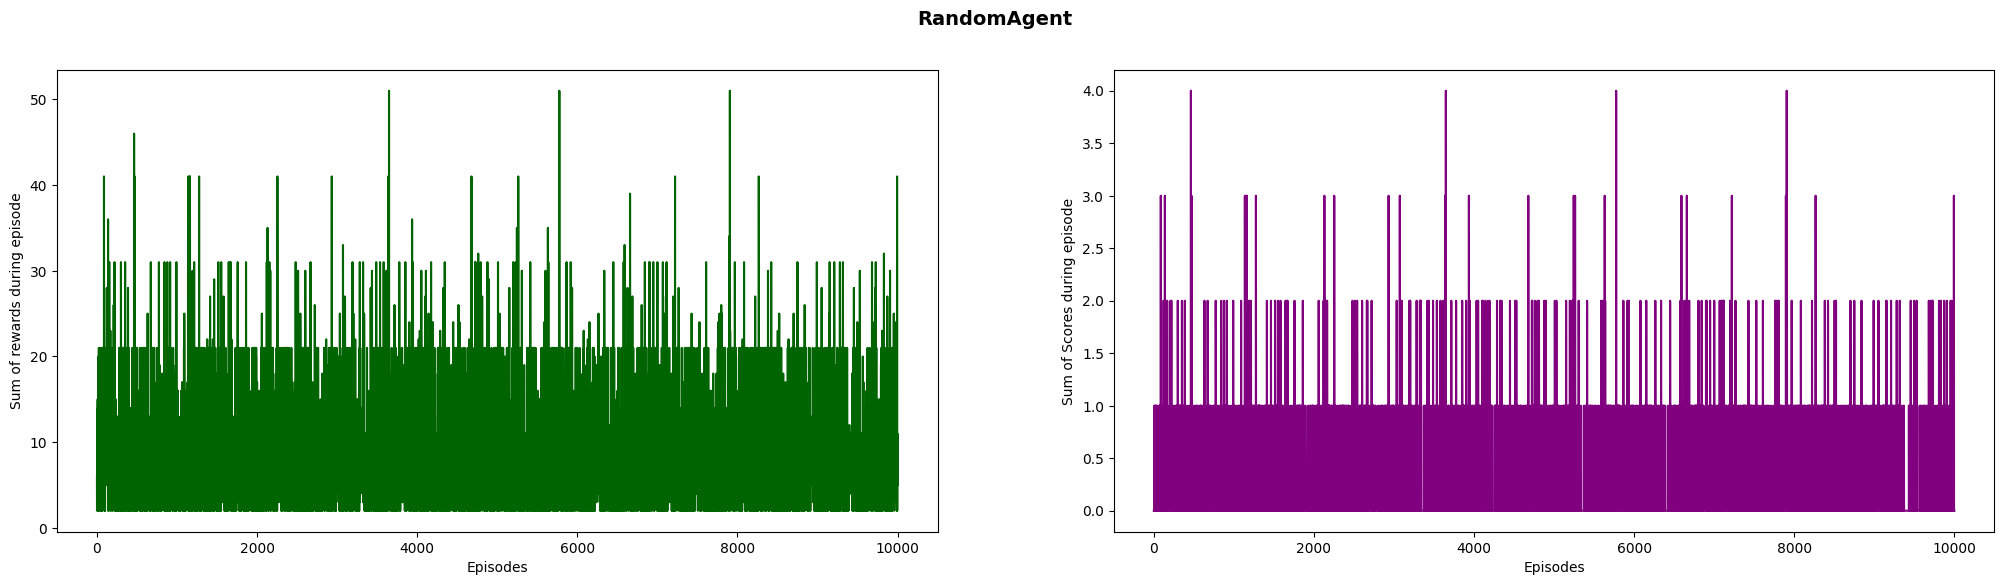

In [96]:
all_reward_sums = {}
all_scores_sums = {}
q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.

if __name__ == '__main__':
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    
    for algorithm in ["Q-learning", "Sarsa", "RandomAgent"]:
        params =  {'epsilon': 0.1, 'alpha': 0.2, 'gamma': 0.85, 'epsilon_decay': 0.999, 'alpha_decay': 0.9999}
        train_agent(algorithm, params)
        plot_charts([algorithm], colors)
                


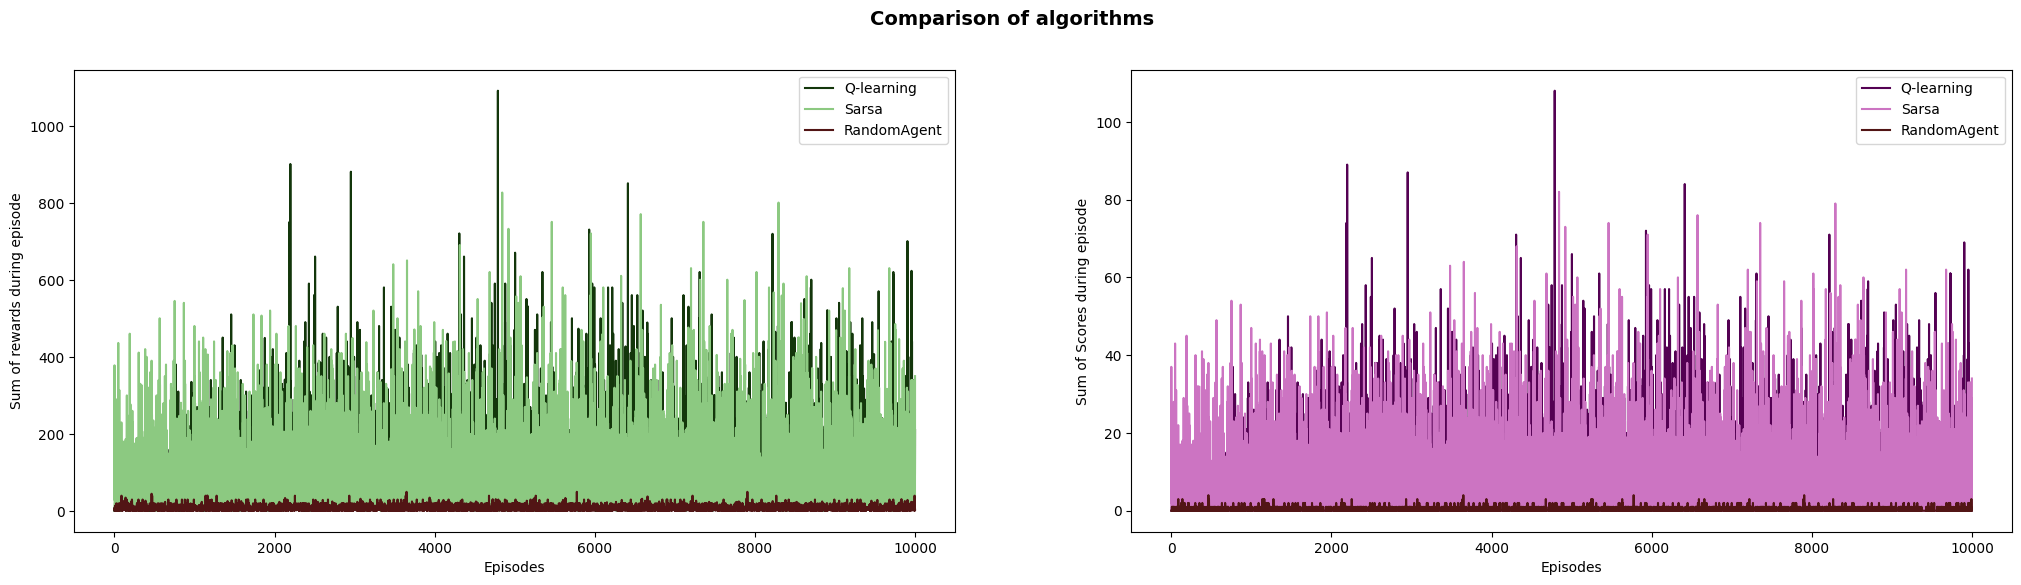

In [97]:
colors_group = (['#13360b','#8cc981', '#521515'],['#540153', '#cc74c2', '#521515'])
plot_charts([ "Q-learning", "Sarsa", "RandomAgent" ], colors_group)